### Explore Attributes and Class

_Identify and explain interesting relationships between features and the class you are trying to predict (i.e., relationships with variables and the target classification)._


In [85]:
#import the data
import pandas as pd
df = pd.read_csv('C:/Users/bsnxw01/Desktop/MSDS_Program/MSDS_7331/Project/Lab1/DataMiningGroupProjects/Project1/Input/DefaultCreditcardClients.csv')
df.rename(columns={'default payment next month':'default'}, inplace=True)
#df.dtypes


Below are several of the data clean-up tasks that have already been done and a couple that I did to help me better understand the data

In [86]:
import numpy as np

# Change numeric values to floats
continuous_features = ['LIMIT_BAL', 'BILL_AMT1', 'BILL_AMT2','BILL_AMT3',
                       'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
                       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5',
                       'PAY_AMT6']
#ordinal_features = ['EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0','PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
#categ_features = ['ID', 'SEX', 'default'];
df[continuous_features] = df[continuous_features].astype(np.float64)

#convert any non-identified education categories to 'OTHER'
df['EDUCATION'] = df['EDUCATION'].replace(to_replace=(0,5,6),value=4)

#convert any non-identified marriage categories to 'OTHER'
df['MARRIAGE'] = df['MARRIAGE'].replace(to_replace=(0),value=3)

#calculate the credit usage values
df['USAGE_1'] = df['BILL_AMT1']/df['LIMIT_BAL']
df['USAGE_2'] = df['BILL_AMT2']/df['LIMIT_BAL']
df['USAGE_3'] = df['BILL_AMT3']/df['LIMIT_BAL']
df['USAGE_4'] = df['BILL_AMT4']/df['LIMIT_BAL']
df['USAGE_5'] = df['BILL_AMT5']/df['LIMIT_BAL']
df['USAGE_6'] = df['BILL_AMT6']/df['LIMIT_BAL']

#transform continuous variables as they each have a mostly exponential distribution
df[continuous_features] = df[continuous_features].replace(to_replace=0,value=np.nan).apply(np.log)

df.dtypes


ID             int64
LIMIT_BAL    float64
SEX            int64
EDUCATION      int64
MARRIAGE       int64
AGE            int64
PAY_0          int64
PAY_2          int64
PAY_3          int64
PAY_4          int64
PAY_5          int64
PAY_6          int64
BILL_AMT1    float64
BILL_AMT2    float64
BILL_AMT3    float64
BILL_AMT4    float64
BILL_AMT5    float64
BILL_AMT6    float64
PAY_AMT1     float64
PAY_AMT2     float64
PAY_AMT3     float64
PAY_AMT4     float64
PAY_AMT5     float64
PAY_AMT6     float64
default        int64
USAGE_1      float64
USAGE_2      float64
USAGE_3      float64
USAGE_4      float64
USAGE_5      float64
USAGE_6      float64
dtype: object

### Explore Attributes and Class

_Identify and explain interesting relationships between features and the class you are trying to predict (i.e., relationships with variables and the target classification)._

In order to understand the potential model we would use and how we may want to select certain features or potentially identify new features for us in our model we took a look at how each of the variables relate to our default categories (1/0).


In [38]:
# this python magics will allow plot to be embedded into the notebook
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
warnings.simplefilter('ignore', DeprecationWarning)
%matplotlib inline

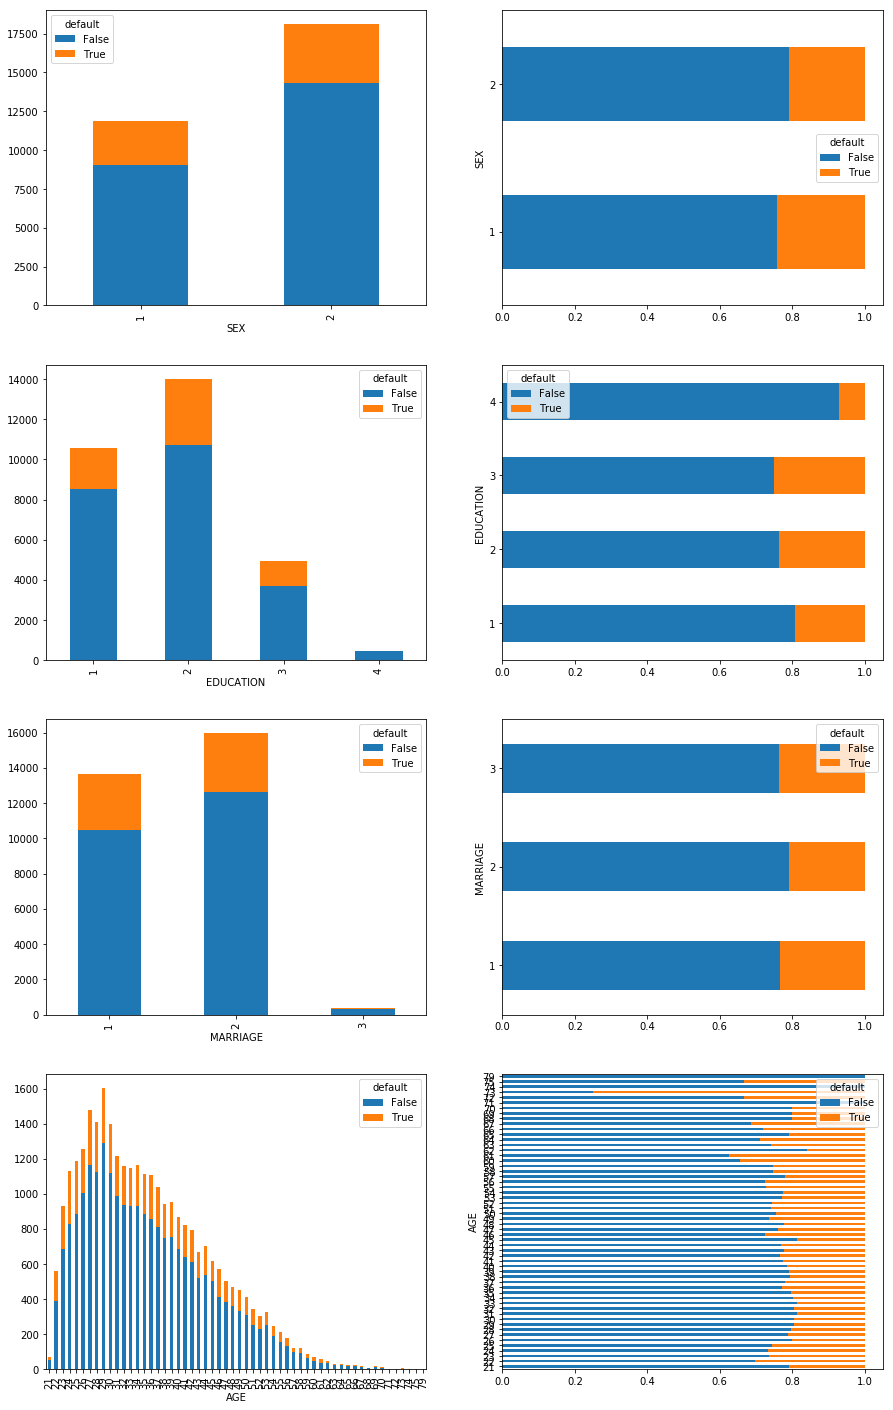

In [26]:
# cross tabs provide a quick view of the relationships between different categorical variable & our target
# beginning with the characteristics of the borrower

plotVar = ['SEX','EDUCATION','MARRIAGE','AGE']

fig, axes = plt.subplots(nrows=len(plotVar), ncols=2, figsize=(15, 25))

for fi,feature in enumerate(plotVar):
    Counts = pd.crosstab(df[feature],df.default.astype(bool))
    Counts.plot(kind='bar', stacked=True, ax=axes[fi,0])
    
    Rate = Counts.div(Counts.sum(1).astype(float),axis=0)
    Rate.plot(kind='barh', stacked=True, ax=axes[fi,1])
    
plt.show()


After reviewing the features from above there are a couple relationships that stand out when comparing the demographic features and the proportion of defaults for our sample. 

Sex
- There does appear to be a noticeable difference in the default rates by gender based on a visual inspection.

Education
- There does seem to pattern between the amount of education people receive and the default rates. Based on the visual inspection of the above data there is some indication that people with higher levels of education default at lower rates.

Marriage
- There does not seem to be any obvious discernable trends based on Marital Status

Age:
- Based on the age variables there is potentially some indications that people in there early 20's are more succeptible to defaulting, however this variable may need to be bucketed differently to better interpret the succeptible age groups.


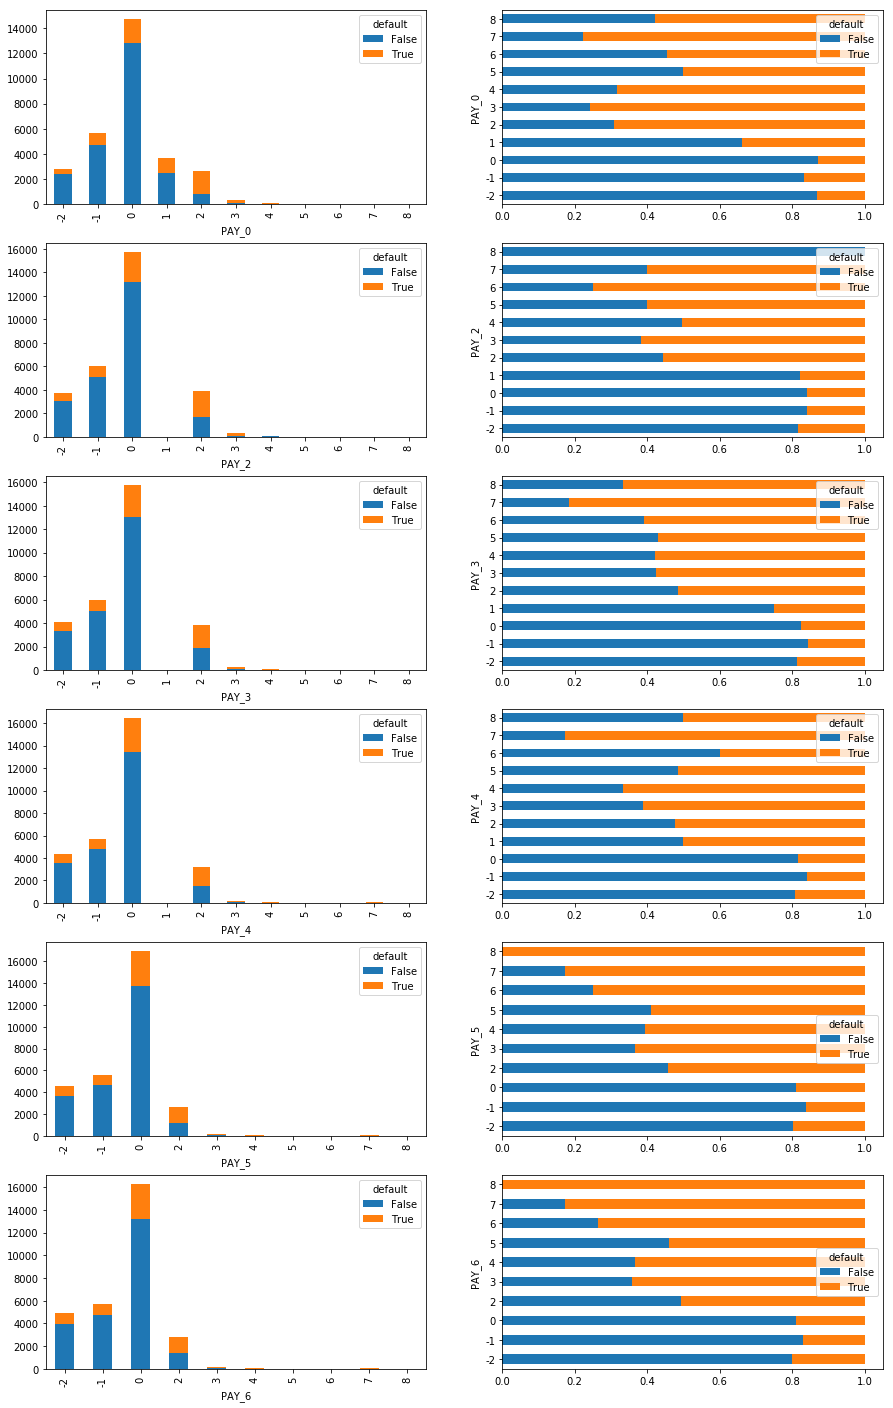

In [40]:
plotVar = ['PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6']

fig, axes = plt.subplots(nrows=len(plotVar), ncols=2, figsize=(15, 25))

for fi,feature in enumerate(plotVar):
    Counts = pd.crosstab(df[feature],df.default.astype(bool))
    Counts.plot(kind='bar', stacked=True, ax=axes[fi,0])
    
    Rate = Counts.div(Counts.sum(1).astype(float),axis=0)
    Rate.plot(kind='barh', stacked=True, ax=axes[fi,1])
    
plt.show()

When we review the payment status it is pretty apparent that a history a late payments is potentially a pretty strong indication that person will default on there next payment. Based on the people that paid 2 or more months late in April of 2005, ~60% went on to default on there next payment. Logically this makes sense, as  person who is behind on payments seems less likely to be able to catch up in the following months. The current categorization method for tracking this is fairly coarse and could potentially be improved on. We will consider potential ways to utilize these features in our new features section below.

In order to better understand this behavior we will look at the prior bills and payment history to better understand the relationships between prior payments and the subsequent default result.

Text(0,0.5,'Average Months Behind Payment Due Date')

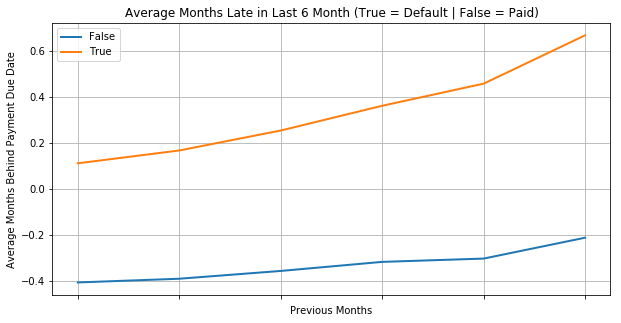

In [82]:
plotVar = ['PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6','default']
plotDF = df[plotVar]

meanDF = plotDF.groupby(by='default').mean().T.reset_index()
meanDF['Month'] = [9,8,7,6,5,4]
meanDF.columns = ['PreviousMonths', 'False', 'True', 'Month']
meanDF = meanDF.sort_values(by=['Month'], ascending=True)

meanDF.plot(x='PreviousMonths', y=['False', 'True'], figsize=(10,5), grid=True, lw = 2)
plt.title('Average Months Late in Last 6 Month (True = Default | False = Paid)')
plt.xlabel('Previous Months')
plt.ylabel('Average Months Behind Payment Due Date')

From above there is some evidence that the customers that default on their payments appear to be being paying there previous bills later customers that don't. Additionally, it appears that as we move closer to the month we are predicting(left to right), the timeliness of the bill payments seems to be getting worse.

This is supported by the fact that we are seeing >50% of customers who default have some history of being late on 1 or more payments.

Logically it makes since as people who have trouble paying there previous bills will likely have similar difficulties paying in the future. Espectially if they are behind on the bill from the previous month, then one would assume the liklihood of defaulting would increase.

*It should be mentioned that we are limited in our knowledge of how this data was collected, so the patterns seen could be afactor of how these were derived.*

Text(0,0.5,'Average Log(Bill Amt)')

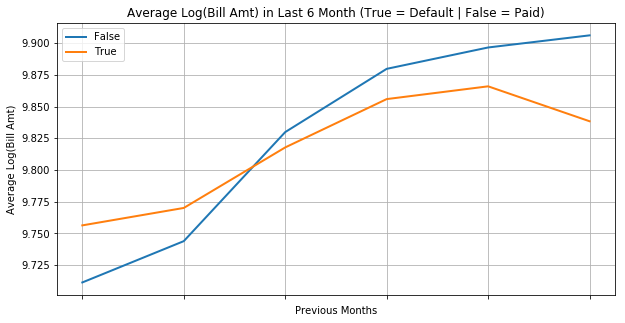

In [83]:
plotVar = ['BILL_AMT1', 'BILL_AMT2','BILL_AMT3','BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6','default']
plotDF = df[plotVar]

meanDF = plotDF.groupby(by='default').mean().T.reset_index()
meanDF['Month'] = [9,8,7,6,5,4]
meanDF.columns = ['PreviousMonths', 'False', 'True', 'Month']
meanDF = meanDF.sort_values(by=['Month'], ascending=True)

meanDF.plot(x='PreviousMonths', y=['False', 'True'], figsize=(10,5), grid=True, lw = 2)
plt.title('Average Log(Bill Amt) in Last 6 Month (True = Default | False = Paid)')
plt.xlabel('Previous Months')
plt.ylabel('Average Log(Bill Amt)')

When looking at the bill amount from the previous months there does not seem to be a considerable difference between the median bill between customers that default and those that don't. So it would seem that the actual bill amount by itself will offer little insight into the likelihood of default. This is perhaps an indication that it should be considered relative to the total available credit and the prior payments.

Text(0,0.5,'Average Log(Pay Amt)')

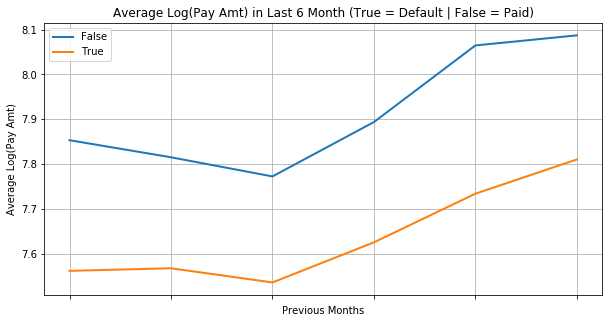

In [84]:
plotVar = ['PAY_AMT1', 'PAY_AMT2','PAY_AMT3','PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6','default']
plotDF = df[plotVar]

meanDF = plotDF.groupby(by='default').mean().T.reset_index()
meanDF['Month'] = [9,8,7,6,5,4]
meanDF.columns = ['PreviousMonths', 'False', 'True', 'Month']
meanDF = meanDF.sort_values(by=['Month'], ascending=True)

meanDF.plot(x='PreviousMonths', y=['False', 'True'], figsize=(10,5), grid=True, lw = 2)
plt.title('Average Log(Pay Amt) in Last 6 Month (True = Default | False = Paid)')
plt.xlabel('Previous Months')
plt.ylabel('Average Log(Pay Amt)')

There does appear to be a difference in the median payment amount between the customers that defaulted and those that did not. We see here that that customers that did not default had also been making higher payments against there credit on average than those that do default. This is perhaps corroborating evidence we saw when looking at the timeliness of past payments. This leads us to question if customers that default are paying less, but maintain a similar bill amount then they are likely using a higher proportion of there credit.

Text(0,0.5,'Average Credit Usage Rate')

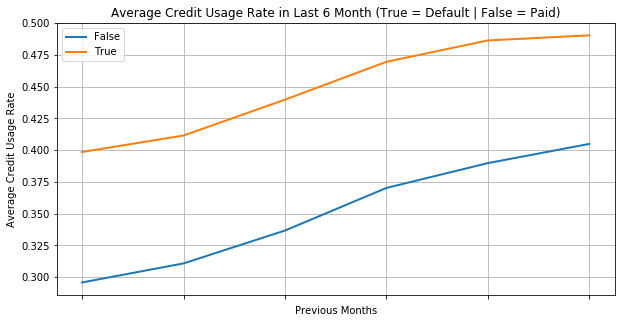

In [87]:
plotVar = ['USAGE_1', 'USAGE_2','USAGE_3','USAGE_4', 'USAGE_5', 'USAGE_6','default']
plotDF = df[plotVar]

meanDF = plotDF.groupby(by='default').mean().T.reset_index()
meanDF['Month'] = [9,8,7,6,5,4]
meanDF.columns = ['PreviousMonths', 'False', 'True', 'Month']
meanDF = meanDF.sort_values(by=['Month'], ascending=True)

meanDF.plot(x='PreviousMonths', y=['False', 'True'], figsize=(10,5), grid=True, lw = 2)
plt.title('Average Credit Usage Rate in Last 6 Month (True = Default | False = Paid)')
plt.xlabel('Previous Months')
plt.ylabel('Average Credit Usage Rate')

Once we look at the credit usage between these to customer types it does appear that customers that default have a higher credit utilization when compared to those that do not. With on average customers that default are billed for ~45% of the total available balance versus only ~35% for those that do not. 

Text(0.5,1,'Average Credit Usage Rate')

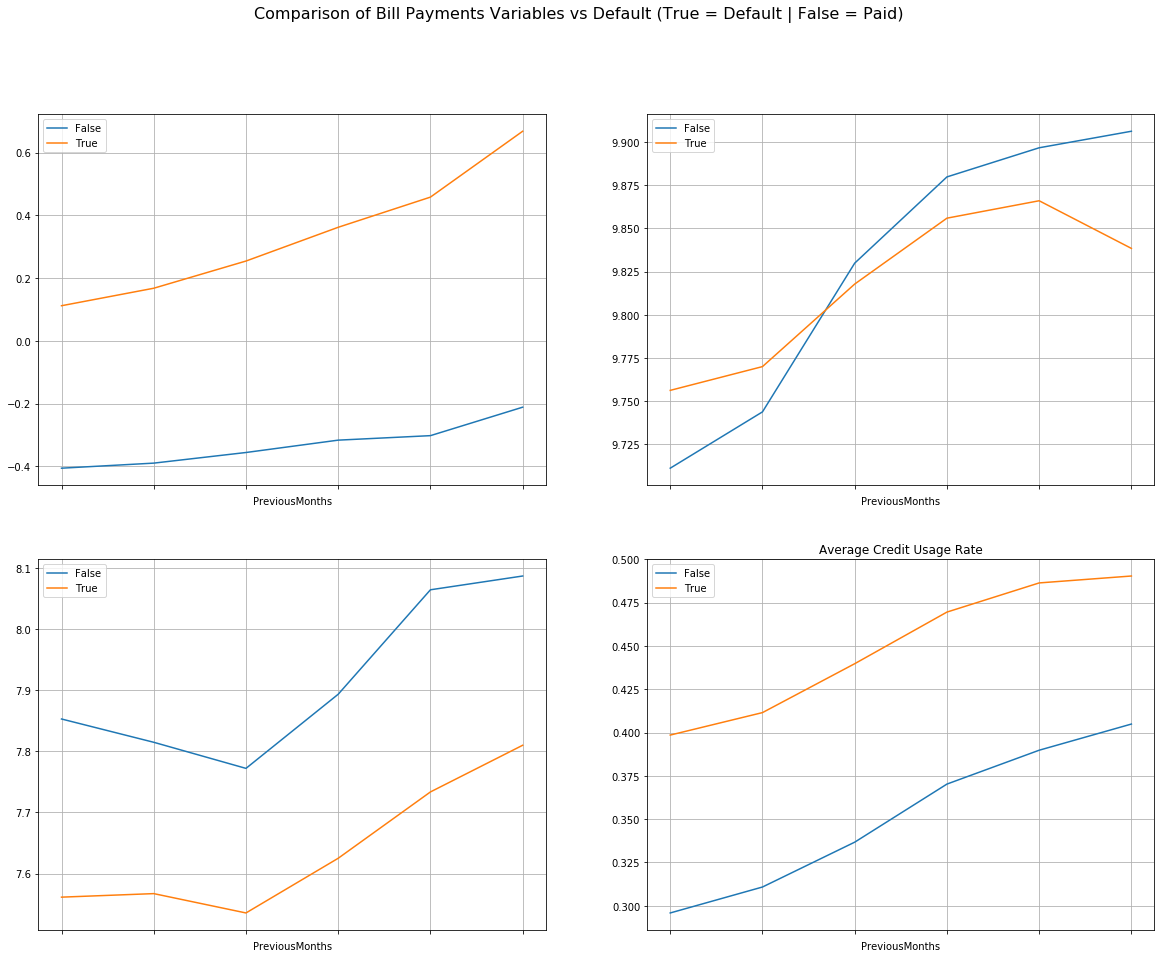

In [105]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 15))
fig.suptitle('Comparison of Bill Payments Variables vs Default (True = Default | False = Paid)', fontsize=16)


# Plot the months late in payments
plotVar = ['PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6','default']
plotDF = df[plotVar]

meanDF = plotDF.groupby(by='default').mean().T.reset_index()
meanDF['Month'] = [9,8,7,6,5,4]
meanDF.columns = ['PreviousMonths', 'False', 'True', 'Month']
meanDF = meanDF.sort_values(by=['Month'], ascending=True)

meanDF.plot(x='PreviousMonths', y=['False', 'True'], grid=True, ax = axes[0,0])
plt.title('Average Months Late')

# Plot the bill amounts
plotVar = ['BILL_AMT1', 'BILL_AMT2','BILL_AMT3','BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6','default']
plotDF = df[plotVar]

meanDF = plotDF.groupby(by='default').mean().T.reset_index()
meanDF['Month'] = [9,8,7,6,5,4]
meanDF.columns = ['PreviousMonths', 'False', 'True', 'Month']
meanDF = meanDF.sort_values(by=['Month'], ascending=True)

meanDF.plot(x='PreviousMonths', y=['False', 'True'], grid=True, ax = axes[0,1])
plt.title('Average Log(Bill Amt)')

#plot the pay amounts
plotVar = ['PAY_AMT1', 'PAY_AMT2','PAY_AMT3','PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6','default']
plotDF = df[plotVar]

meanDF = plotDF.groupby(by='default').mean().T.reset_index()
meanDF['Month'] = [9,8,7,6,5,4]
meanDF.columns = ['PreviousMonths', 'False', 'True', 'Month']
meanDF = meanDF.sort_values(by=['Month'], ascending=True)

meanDF.plot(x='PreviousMonths', y=['False', 'True'], grid=True, ax = axes[1,0])
plt.title('Average Log(Pay Amt)')

#plot the credit usage Amounts
plotVar = ['USAGE_1', 'USAGE_2','USAGE_3','USAGE_4', 'USAGE_5', 'USAGE_6','default']
plotDF = df[plotVar]

meanDF = plotDF.groupby(by='default').mean().T.reset_index()
meanDF['Month'] = [9,8,7,6,5,4]
meanDF.columns = ['PreviousMonths', 'False', 'True', 'Month']
meanDF = meanDF.sort_values(by=['Month'], ascending=True)

meanDF.plot(x='PreviousMonths', y=['False', 'True'], grid=True, ax = axes[1,1])
plt.title('Average Credit Usage Rate')

In [43]:
# transform variables to a simple binary response and jitter the obs to better plot
transformVar = ['PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6']

for fi,feature in enumerate(transformVar):
    df[feature] = pd.cut(df[feature], [-3,-1,8], 2, labels=[0,1]).astype(np.int64)
#     df[feature] = df[feature] + np.random.rand(*df[feature].shape)/2

<bound method NDFrame.head of           ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  \
0          1   9.903488    2          2         1   24      1      1      0   
1          2  11.695247    2          2         2   26      0      1      1   
2          3  11.407565    2          2         2   34      1      1      1   
3          4  10.819778    2          2         1   37      1      1      1   
4          5  10.819778    1          2         1   57      0      1      0   
5          6  10.819778    1          1         2   37      1      1      1   
6          7  13.122363    1          1         2   29      1      1      1   
7          8  11.512925    2          2         2   23      1      0      0   
8          9  11.849398    2          3         1   28      1      1      1   
9         10   9.903488    1          3         2   35      0      0      0   
10        11  12.206073    2          3         2   34      1      1      1   
11        12  12.46843

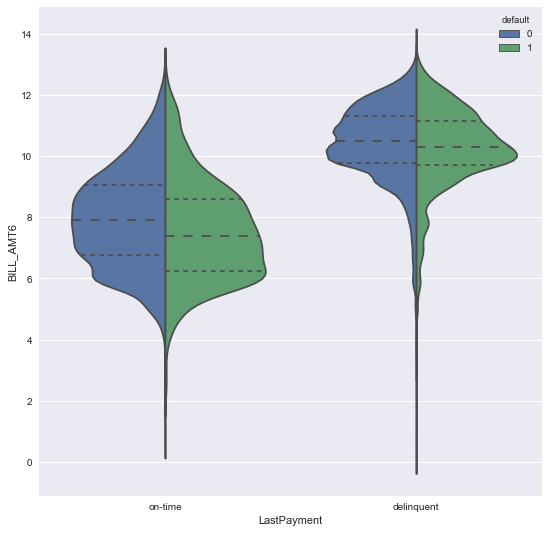

In [125]:
f, ax = plt.subplots(figsize=(9, 9))

sns.violinplot(x="PAY_6", y="BILL_AMT6", hue="default", data=df, 
               split=True, inner="quart")

The above plot shows the distributions of the log transformed bill amounts from the April bill against the different payment results (on-time vs delinquent) for both the defaulted & not defaulted records for the next month.

From the graph above it does appear that the bill amount may have an effect on whether the customer was able to make the payment on time for their April bill. From the graph above payments that are made on time appear to have a lower median bill amount than those that are delinquent. This behavior is consistent for those that default on their next bill.


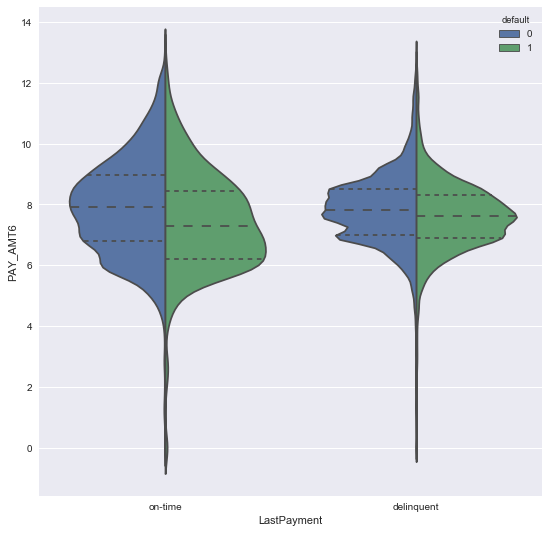

In [126]:
f, ax = plt.subplots(figsize=(9, 9))

sns.violinplot(x="LastPayment", y="PAY_AMT6", hue="default", data=df, 
               split=True, inner="quart")

The above plot shows the distributions of the log transformed payment amounts from the April bill against the different payment results (on-time vs delinquent) for both the defaulted & not defaulted records for the next month.

Interestingly, while the bill amounts may may be lower for on-time payments, the payment amounts do not obviously show the same payment patterns.

### New Features

_Are there other features that could be added to the data or created from existing features? Which ones?_
